In [1]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array





2024-11-28 17:37:29.362839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732786649.371573   10936 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732786649.374044   10936 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 17:37:29.382551: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#To add seed for fix the random state
SEED = 105
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

CLASS_TYPES = ["glioma","meningioma","notumor","pituitary"]
TYPES = 4

root = r"Brain-Train-Data-Set"
train_path = root + "/Training"
test_path = root + "/Testing"

    

In [3]:
## Data Processing & Training Setup Values
# Image Size
image_size = (150,150)

#Training batch size
batch_size = 32


## Data augmentation and presprocessing

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")

# applying the generator to training data with constant random state
train_dataset = train_datagen.flow_from_directory(train_path,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

## rescalin the testing data, no data augmentation applied
test_datagen = ImageDataGenerator(rescale=1./255)

test_dataset = test_datagen.flow_from_directory(test_path,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)

Found 5182 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [4]:
## Define Setup Value for Training models
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)

# Training epochs
epochs = 40

# Steps per epoch
steps_per_epoch = train_dataset.samples // batch_size

# Validation steps
validation_steps = test_dataset.samples // batch_size

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print(f'Steps Per Epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')

Image shape: (150, 150, 3)
Epochs: 40
Batch size: 32
Steps Per Epoch: 161
Validation steps: 40


In [5]:
# Define the model architecture
model = models.Sequential([
    
    # Convolutional layer 1
    Conv2D(32, (4, 4), activation="relu", input_shape=image_shape),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    # Full connect layers
    Dense(512, activation="relu"),
    Dropout(0.5, seed=SEED),
    Dense(TYPES, activation="softmax")
])

model.summary()

# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])
model.compile( loss='categorical_crossentropy', metrics= ['accuracy'])

/home/user/miniconda3/envs/tensorflow/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1732786651.042367   10936 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13553 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 1, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 495,972 (1.89 MB)

 Trainable params: 495,972 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

/home/user/miniconda3/envs/tensorflow/lib/python3.12/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


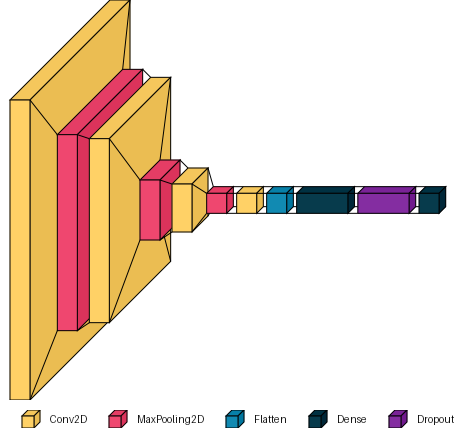

In [6]:
!pip install visualkeras
from visualkeras import layered_view

# Visualize the model
layered_view(model, legend=True, max_xy=300)


In [7]:
# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, verbose=True)


# Training the model

history = model.fit(train_dataset,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_dataset,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr])

/home/user/miniconda3/envs/tensorflow/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40


I0000 00:00:1732786652.908536   11128 service.cc:148] XLA service 0x7fa95000b850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732786652.908574   11128 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2024-11-28 17:37:32.926559: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732786652.986428   11128 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-28 17:37:33.520977: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_939', 16 bytes spill stores, 16 bytes spill loads

2024-11-28 17:37:33.598432: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_939', 1

  3/161 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.2344 - loss: 1.3971

I0000 00:00:1732786654.963530   11128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 48/161 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - accuracy: 0.3294 - loss: 1.3514

2024-11-28 17:37:41.211127: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_939', 20 bytes spill stores, 24 bytes spill loads



161/161 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.4206 - loss: 1.1984 - val_accuracy: 0.7000 - val_loss: 0.7761 - learning_rate: 0.0010
Epoch 2/40
  1/161 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6875 - loss: 0.5689

2024-11-28 17:37:59.605666: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-28 17:37:59.605702: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/user/miniconda3/envs/tensorflow/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6875 - loss: 0.5689 - val_accuracy: 0.7419 - val_loss: 0.6630 - learning_rate: 0.0010
Epoch 3/40
  1/161 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - accuracy: 0.5625 - loss: 0.9550

2024-11-28 17:38:00.750955: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step - accuracy: 0.7232 - loss: 0.6476 - val_accuracy: 0.7727 - val_loss: 0.5207 - learning_rate: 0.0010
Epoch 4/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 183us/step - accuracy: 0.7000 - loss: 0.6658 - val_accuracy: 0.9677 - val_loss: 0.2539 - learning_rate: 0.0010
Epoch 5/40


2024-11-28 17:38:23.049139: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898
2024-11-28 17:38:23.049292: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:38:23.137324: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-28 17:38:23.137356: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:38:23.137369: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898


161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step - accuracy: 0.7925 - loss: 0.5128 - val_accuracy: 0.7844 - val_loss: 0.5724 - learning_rate: 0.0010
Epoch 6/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 134us/step - accuracy: 0.7188 - loss: 0.4502 - val_accuracy: 0.6774 - val_loss: 1.0373 - learning_rate: 0.0010
Epoch 7/40


2024-11-28 17:38:45.378047: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898
2024-11-28 17:38:45.428411: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:38:45.428448: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898


161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - accuracy: 0.8580 - loss: 0.3692 - val_accuracy: 0.7828 - val_loss: 0.5434 - learning_rate: 0.0010
Epoch 8/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step - accuracy: 0.8750 - loss: 0.4940 - val_accuracy: 0.9677 - val_loss: 0.1909 - learning_rate: 0.0010
Epoch 9/40


2024-11-28 17:39:07.379043: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898
2024-11-28 17:39:07.379083: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:39:07.482327: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-28 17:39:07.482357: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:39:07.482371: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898


161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - accuracy: 0.8796 - loss: 0.3177 - val_accuracy: 0.8547 - val_loss: 0.3368 - learning_rate: 0.0010
Epoch 10/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - accuracy: 0.9375 - loss: 0.1491 - val_accuracy: 1.0000 - val_loss: 0.0195 - learning_rate: 0.0010
Epoch 11/40


2024-11-28 17:39:29.048936: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898
2024-11-28 17:39:29.048981: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:39:29.117885: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:39:29.117926: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898


161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.8930 - loss: 0.2960 - val_accuracy: 0.8906 - val_loss: 0.2687 - learning_rate: 0.0010
Epoch 12/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 181us/step - accuracy: 0.8750 - loss: 0.2613 - val_accuracy: 1.0000 - val_loss: 0.0338 - learning_rate: 0.0010
Epoch 13/40


2024-11-28 17:39:50.955829: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898
2024-11-28 17:39:50.955876: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:39:51.057902: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:39:51.057943: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898


161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - accuracy: 0.9157 - loss: 0.2261 - val_accuracy: 0.9219 - val_loss: 0.2041 - learning_rate: 0.0010
Epoch 14/40
  1/161 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.9375 - loss: 0.2437
Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step - accuracy: 0.9375 - loss: 0.2437 - val_accuracy: 0.7419 - val_loss: 0.6146 - learning_rate: 0.0010
Epoch 15/40


2024-11-28 17:40:12.947667: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898
2024-11-28 17:40:12.947707: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:40:13.049032: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:40:13.049077: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898


161/161 ━━━━━━━━━━━━━━━━━━━━ 23s 141ms/step - accuracy: 0.9556 - loss: 0.1295 - val_accuracy: 0.9492 - val_loss: 0.1524 - learning_rate: 3.0000e-04
Epoch 16/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 173us/step - accuracy: 0.9688 - loss: 0.0676 - val_accuracy: 1.0000 - val_loss: 0.0037 - learning_rate: 3.0000e-04
Epoch 17/40


2024-11-28 17:40:35.855862: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898
2024-11-28 17:40:35.855899: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:40:35.949637: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-28 17:40:35.949690: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:40:35.949726: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898


161/161 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.9686 - loss: 0.0883 - val_accuracy: 0.9602 - val_loss: 0.1200 - learning_rate: 3.0000e-04
Epoch 18/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step - accuracy: 1.0000 - loss: 0.0456 - val_accuracy: 1.0000 - val_loss: 0.0039 - learning_rate: 3.0000e-04
Epoch 19/40
  1/161 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - accuracy: 1.0000 - loss: 0.0431

2024-11-28 17:40:58.550153: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898
2024-11-28 17:40:58.550192: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:40:58.605301: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:40:58.605339: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898


161/161 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - accuracy: 0.9714 - loss: 0.0814 - val_accuracy: 0.9617 - val_loss: 0.1137 - learning_rate: 3.0000e-04
Epoch 20/40
  1/161 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.9688 - loss: 0.0711
Epoch 20: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - accuracy: 0.9688 - loss: 0.0711 - val_accuracy: 1.0000 - val_loss: 0.0082 - learning_rate: 3.0000e-04
Epoch 21/40


2024-11-28 17:41:21.474919: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898
2024-11-28 17:41:21.474962: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:41:21.558681: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:41:21.558724: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898


161/161 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - accuracy: 0.9769 - loss: 0.0598 - val_accuracy: 0.9648 - val_loss: 0.1102 - learning_rate: 9.0000e-05
Epoch 22/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 181us/step - accuracy: 0.9375 - loss: 0.0964 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 9.0000e-05
Epoch 23/40


2024-11-28 17:41:44.545330: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898
2024-11-28 17:41:44.545365: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:41:44.635337: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:41:44.635378: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898


161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.9822 - loss: 0.0496 - val_accuracy: 0.9633 - val_loss: 0.1075 - learning_rate: 9.0000e-05
Epoch 24/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 147us/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 1.0000 - val_loss: 0.0016 - learning_rate: 9.0000e-05
Epoch 25/40


2024-11-28 17:42:06.357214: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898
2024-11-28 17:42:06.357258: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:42:06.415765: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:42:06.415801: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898


161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 137ms/step - accuracy: 0.9849 - loss: 0.0428 - val_accuracy: 0.9703 - val_loss: 0.1059 - learning_rate: 9.0000e-05
Epoch 26/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 100us/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 0.0011 - learning_rate: 9.0000e-05
Epoch 27/40


2024-11-28 17:42:28.544406: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898
2024-11-28 17:42:28.544445: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:42:28.591848: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:42:28.591884: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898


161/161 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.9859 - loss: 0.0481 - val_accuracy: 0.9711 - val_loss: 0.1038 - learning_rate: 9.0000e-05
Epoch 28/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 179us/step - accuracy: 0.9688 - loss: 0.1178 - val_accuracy: 1.0000 - val_loss: 0.0042 - learning_rate: 9.0000e-05
Epoch 29/40


2024-11-28 17:42:51.208533: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898
2024-11-28 17:42:51.305274: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:42:51.305312: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898


161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.9867 - loss: 0.0517 - val_accuracy: 0.9750 - val_loss: 0.0966 - learning_rate: 9.0000e-05
Epoch 30/40
  1/161 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 1.0000 - loss: 0.0280
Epoch 30: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - accuracy: 1.0000 - loss: 0.0280 - val_accuracy: 1.0000 - val_loss: 0.0010 - learning_rate: 9.0000e-05
Epoch 31/40


2024-11-28 17:43:13.147125: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898
2024-11-28 17:43:13.147161: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:43:13.246735: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:43:13.246779: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898


161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.9850 - loss: 0.0505 - val_accuracy: 0.9734 - val_loss: 0.1006 - learning_rate: 2.7000e-05
Epoch 32/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step - accuracy: 0.9688 - loss: 0.0548 - val_accuracy: 1.0000 - val_loss: 0.0012 - learning_rate: 2.7000e-05
Epoch 33/40


2024-11-28 17:43:35.078260: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898
2024-11-28 17:43:35.078297: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:43:35.137272: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-28 17:43:35.137305: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:43:35.137319: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898


161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.9906 - loss: 0.0351 - val_accuracy: 0.9734 - val_loss: 0.0943 - learning_rate: 2.7000e-05
Epoch 34/40
  1/161 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.9688 - loss: 0.0604
Epoch 34: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step - accuracy: 0.9688 - loss: 0.0604 - val_accuracy: 1.0000 - val_loss: 0.0011 - learning_rate: 2.7000e-05
Epoch 34: early stopping


2024-11-28 17:43:56.918194: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898
2024-11-28 17:43:56.918231: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:43:57.009185: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10426559310247027948
2024-11-28 17:43:57.009222: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16463689898673189898


In [8]:
# Evaluating the model
loss, accuracy = model.evaluate(test_dataset, steps=test_dataset.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.9631 - loss: 0.1267
Test Loss: 0.09703
Test Accuracy: 0.97266


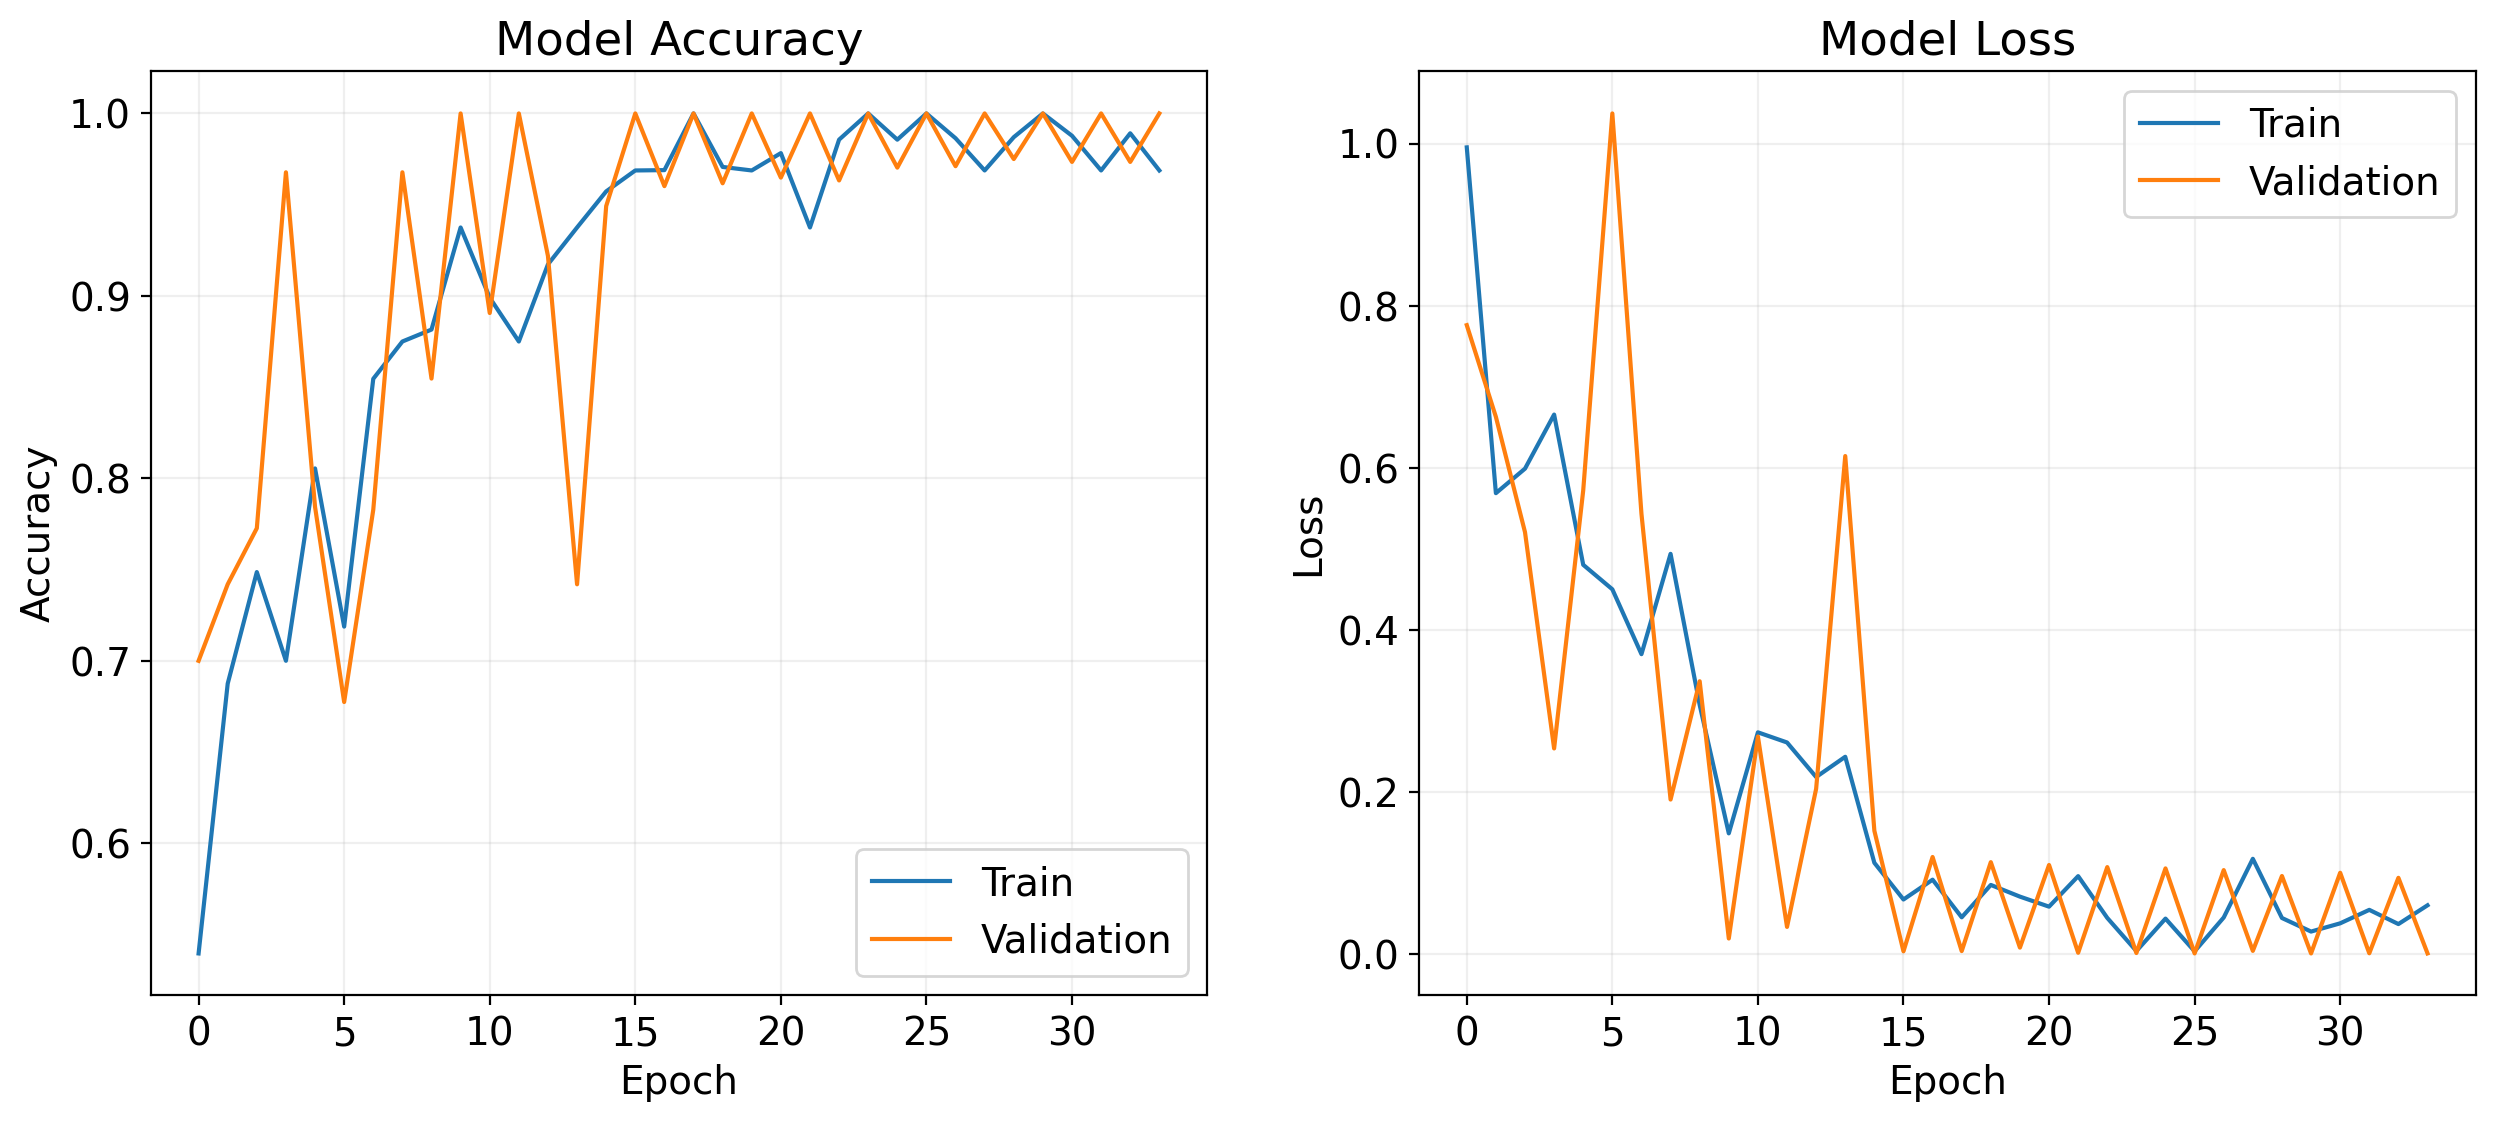

<Figure size 1600x1000 with 0 Axes>

In [9]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()
plt.savefig("Acc_Loss.jpg")

In [10]:
def plot_sample_predictions(model, test_generator, categories, test_dir, num_samples=9, figsize=(12, 8)):
    # Make predictions on the test dataset
    predictions = model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Randomly sample test images
    test_images = np.array(test_generator.filepaths)
    sample_indices = np.random.choice(len(test_images), size=num_samples, replace=False)
    sample_images = test_images[sample_indices]
    sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
    sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

    # Plot sample images with their predicted and true labels
    plt.figure(figsize=figsize)
    
    # Loop over samples
    for i, image_path in enumerate(sample_images):
        # Form subplot and plot
        plt.subplot(3, 3, i + 1)
        img = plt.imread(image_path)
        plt.imshow(img)
        plt.axis("off")
        
        # Set axis label color depending on correct prediction or not
        prediction_color = 'green' if sample_predictions[i] == sample_true_labels[i] else 'red'
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color=prediction_color)
        
    plt.tight_layout()
    plt.show()


def CM(CNN_model, test_generator, categories):
   
    from sklearn.metrics import confusion_matrix
    # Predictions on test dataset
    predictions = CNN_model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Create a confusion matrix
    confusion_matrix_array = confusion_matrix(true_categories, predicted_categories)
    
    return confusion_matrix_array

def calculate_metrics(confusion_matrix, categories):
    # Calculating 4 different metrics
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

    # Printing the results based on each category
    for i, category in enumerate(categories):
        print(f"Class: {category.title()}")
        print(f"Precision: {precision[i]:.3f}")
        print(f"Recall: {recall[i]:.3f}")
        print(f"F1-Score: {f1_score[i]:.3f}\n")
        
    # Showing the total accuracy of the model
    print(f"\nAccuracy: {accuracy:.3f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step


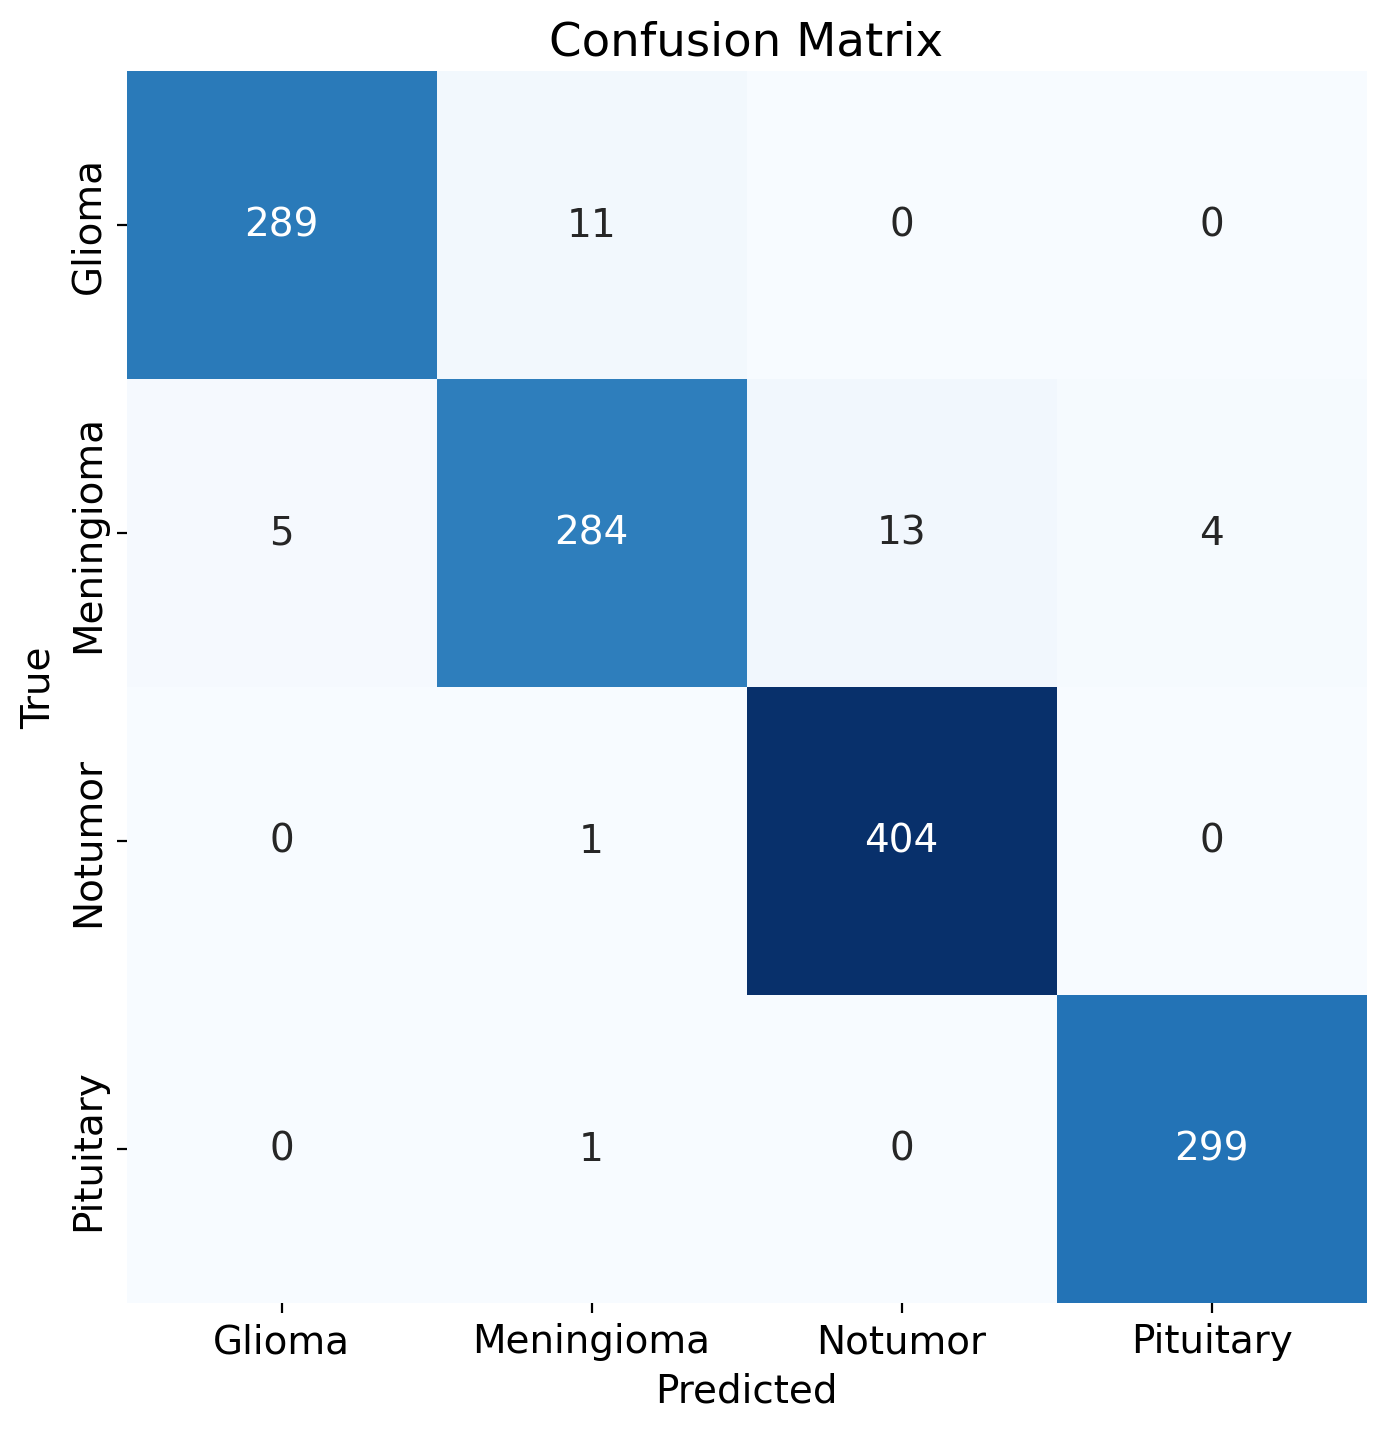

In [11]:
# Plotting confusion matrix
class_indices_train_list = list(train_dataset.class_indices.keys())
confusion_matrix = CM(CNN_model=model, test_generator=test_dataset, categories=class_indices_train_list)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(4) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center')
plt.yticks(ticks=np.arange(4) + 0.5, 
           labels=[name.title() for name in class_indices_train_list], va='center')
plt.show()

In [12]:
# Showing metrics
calculate_metrics(confusion_matrix, categories=class_indices_train_list)

Class: Glioma
Precision: 0.983
Recall: 0.963
F1-Score: 0.973

Class: Meningioma
Precision: 0.956
Recall: 0.928
F1-Score: 0.942

Class: Notumor
Precision: 0.969
Recall: 0.998
F1-Score: 0.983

Class: Pituitary
Precision: 0.987
Recall: 0.997
F1-Score: 0.992


Accuracy: 0.973


In [14]:
model.save('multiclass_0.973.keras')